In [28]:
from sympy import *
init_printing()

import numpy as np
import matplotlib.pyplot as plt

### Notation

$d_q$: queuing delay

$w$: congestion window

$R_m$: minimum RTT (propagation delay)

$\mu$: link rate

$B = \mu R_m$: BDP

$R = w/\mu$: RTT

Note, $d_q = \left(\frac{w - B}{\mu}\right)^+$


### Stability condition

For an instant TCP, let $\tau(d_q, w)$ give the target congestion window. It is stable only if 

$$ -\frac{\pi}{2} < \frac{d \tau(d_q, w)}{d w} < 0 $$

Remember, we need to consider $d_q$'s dependence on $w$ in the derivative.

Note, in some of these analysis, we get one of the solutions of equilibrium cwnd as 0. This could cause starvation of flows. To avoid it, we should analyse the stability of that equilibrium.

In [2]:
d_q, w, R_m, mu, B, R = symbols('d_q w R_m \\mu B R')

# Some identities. Notation: (LHS, RHS) for the identity LHS=RHS
ident_B = (B, mu * R_m)
ident_R_m = (R_m, B / mu)
ident_R = (R, w / mu)
ident_d_q = (d_q, (w - B) / mu)

# Stabilizing Instant TCP

### Sqrt Instant TCP
Consider an instant TCP of the form $\tau(d_q, w) = \frac{\alpha(w) R}{\sqrt{d_q}}$. We need to find $\alpha(w)$ such that this is stable. We picked sqrt because we believe that it will lead to a unique equilibrium point irrespective of the number of senders.

**Note:** Turns out this intuition was wrong, since when we solve for $\alpha$, we get a $w$ in the numerator which leads to infinitely many solutions. This leads to unfairness. Note, this doesn't occur if we have a lower bound on BDP

Now, assume that, instead of writing $\alpha$ as a function of cwnd, we can write it in terms of the BDP, $B$. In some cases, this will still lead to a stable solution.


In [44]:
tau, alpha = symbols('\\tau \\alpha')

tau = alpha * R / sqrt(d_q)

Let us first find the equilibirum cwnd size for this, $w_0$

In [45]:
eqn = (tau - w).subs(*ident_d_q).subs(*ident_R)
w_0 = solve(eqn, w)[1]
w_0

Now, to apply the stability condition we differentiate $\tau$, set it to $-\pi/2$ and solve for $\alpha$

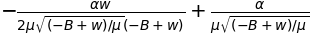

In [46]:
# Differentiate
dtau_dw = diff(tau.subs(*ident_d_q).subs(*ident_R), w)
dtau_dw

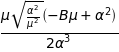

In [6]:
# Substitute w_0 and simplify
dtau_dw__2 = simplify(dtau_dw.subs(w, w_0))
dtau_dw__2

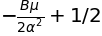

In [47]:
# Manual simplify assuming variables are positive and positive square roots (for show only, not calculations)
# Note: if we want a real alpha, we must pick the negative square root 
(1 - B * mu / alpha ** 2) / 2

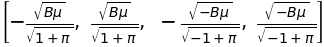

In [7]:
# Set to pi/2 and solve for alpha
alpha_solns = solve(dtau_dw__2 - pi / 2, alpha)
alpha_solns

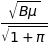

In [8]:
# Pick the real and positive solution
alpha_soln = alpha_solns[1]
alpha_soln

We now have an alpha for which this algorithm should be stable. Let's see what the resultant $tau(d_q, w)$ looks like

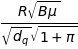

In [9]:
tau_with_B = tau.subs(alpha, alpha_soln)
tau_with_B

In practice, we estimate $B$ as $B = w * R_m / R$. Let's plug that in

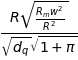

In [10]:
simplify(tau_with_B.subs(B, w * R_m / R).subs(mu * R_m, B).subs(B, w * R_m / R))

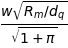

In [52]:
# Manual simplification (just for showing)
w * sqrt(R_m / (d_q * (1 + pi)))

### General Instant TCP
Following the pattern we notice for copa and sqrt, we conjecture a general form as:

$$ \tau = k * w * \left(\frac{R_m}{d_q}\right)^m $$

Note, we assume that the power of $w$ is going to be 1, since that is what we saw previously

In [59]:
tau, alpha, k, l, m = symbols('\\tau \\alpha k l m')
# The base equation
tau = k * w * (R / d_q) ** m
tau

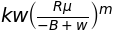

In [60]:
# tau in terms of B and w
tau_wB = tau.subs(*ident_d_q).subs(*ident_R_m)
tau_wB

In [61]:
# Solve for the equilibirum condition
w_eq = solve(tau_wB - w, w)[1]
w_eq

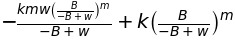

In [19]:
# Derivative of tau
dtau_dw = diff(tau_wB, w)
dtau_dw

In [15]:
# Derivative at equilibrium
dtau_dw__2 = simplify(dtau_dw.subs(w, w_eq))
dtau_dw__2

In [26]:
# Manual simplification (just for showing, not calculating)
1 - m*((1 / k) ** (1/m) + 1)


In [51]:
# Find a k that satisfies that the derivative is smaller than pi / 2 for any m
k_stable = solve(dtau_dw__2 - pi/2, k)[0]
k_stable

In [48]:
# Plot k_stable as a function of m
m_plt = np.linspace(0, 2, 10)
[k_stable.evalf(subs={m: x}) for x in m_plt]
k_stable.evalf(subs={m: 0.5})

### General TCP 2
Another way to calculate a general version where we assume $\tau$ of the form:

$$ \tau = \alpha R * d_q^m $$

In [63]:
tau, alpha, m = symbols('\\tau \\alpha m')

tau = alpha * R * d_q ** m
tau

In [72]:
# Alternate form
tau_wB = tau.subs(*ident_R).subs(*ident_d_q)
tau_wB

In [74]:
# Find equilibrium point
w_eq = solve(w - tau_wB, w)[1]
w_eq

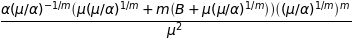

In [77]:
# Differentiate tau and substitute equilibrium value
dtau_dw = simplify(diff(tau_wB, w).subs(w, w_eq))
dtau_dw

In [80]:
# Find an alpha that satisfies condition
alpha_soln = solve(dtau_dw - pi / 2, alpha)[0]
alpha_soln

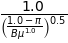

In [82]:
alpha_soln.subs(m, -1 / 2)

# Oscillating Instant TCP
We set the cwnd as follows:
$$ w(t) = b(t) + a(t)\sin{\omega t} $$

$b(t)$ is the 'base' congestion window and controls efficiency. $a(t)$ is the amplitude. This is what senders observe to ensure fairness. $\omega$ is a global oscillation frequency. We set $a(t) = s b(t)$ for some constant $s$. Let us look at the amplitude of oscillation of the queuing delay:

$$ d_{osc} = 
\begin{cases} 
    2a = 2sb & b - a = (1 - s)b \ge B \\
    b + a - B = (1 + s)b - B & b + a = (1 + s)b \ge B \:\mathrm{and}\: (1 - s)b \le B \\
    0 & otherwise
\end{cases}
$$

We consider an update rule of the form:

$$ b_{target} = \frac{\alpha R_{mid}}{d_{osc}} $$

for some $\alpha$ which may be a function of $B$. As before, $B$ can be estimated as $w R_m / R$. Here, $R_{mid}$ is the middle RTT, so $R_{mid} = \frac{b}{\mu}$

In [150]:
s, b, d_osc, R_mid, alpha = symbols('s b d_{osc} R_{mid} \\alpha')
ident_d_osc_1 = (d_osc, (1 + s) * b - B)
ident_d_osc_2 = (d_osc, 2 * s * b)
ident_R_mid = (R_mid, b / mu)

In [151]:
# The target
b_target = alpha * R_mid / d_osc
b_target

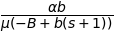

In [152]:
# Write in terms of b and B
b_target_bB = b_target.subs(*ident_d_osc_1).subs(*ident_R_mid)
b_target_bB

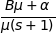

In [153]:
# Solve for equilibrium b.
b_eq = solve(b_target_bB - b, b)[1] # Note, 0 is also a solution here
b_eq

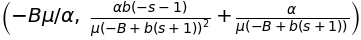

In [154]:
# Differentiate and substitute equilibrium
db_target_db_eq = simplify(diff(b_target_bB, b).subs(b, b_eq))
db_target_db_eq, diff(b_target_bB, b)

In [155]:
# Pick alpha to meet stability condition
alpha_soln = solve(db_target_db_eq - pi / 2, alpha)[0]
alpha_soln

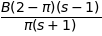

In [168]:
# Now, find an 's' such that b - a = B, and the queue empties periodically. 
# First compute b - a at equilibrium with the given alpha
b_eq_minus_a = simplify(b_eq.subs(alpha, alpha_soln) * (1 - s))
b_eq_minus_a

In [169]:
# Find s
s_soln = solve(b_eq_minus_a - B, s)[0]
s_soln

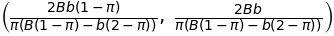

In [163]:
# Final formula
b_final = simplify(b_target_bB.subs(alpha, alpha_soln).subs(s, s_soln))
a_final = simplify((b_final * s).subs(s, s_soln))
(b_final, a_final)